In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import sys

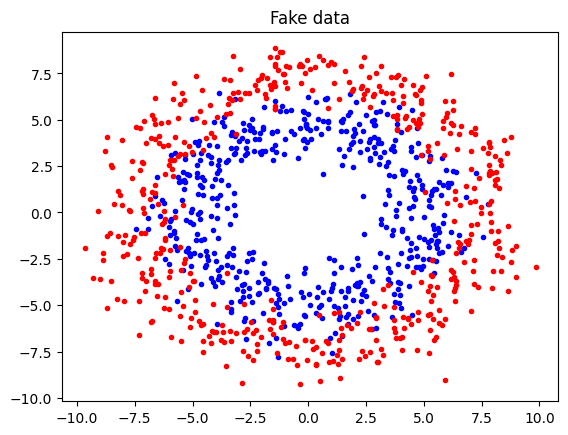

In [12]:
# make data
nPerClust = 500
th = np.linspace(0, 10 * np.pi, nPerClust)
r1 = 5
r2 = 7.5
blur = 1

a = np.array(
    [
        np.cos(th) * r1 + np.random.randn(nPerClust) * blur,
        np.sin(th) * r1 + np.random.randn(nPerClust) * blur,
    ]
)
b = np.array(
    [
        np.cos(th) * r2 + np.random.randn(nPerClust) * blur,
        np.sin(th) * r2 + np.random.randn(nPerClust) * blur,
    ]
)

labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))
data_np = np.hstack((a, b)).T

data = torch.tensor(data_np, dtype=torch.float)
labels = torch.tensor(labels_np, dtype=torch.float)

plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "b.")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "r.")
plt.title("Fake data")
plt.show()

In [13]:
# split data
train_data, test_data, train_labels, test_labels = train_test_split(
    data_np, labels_np, test_size=0.2
)
train_data = TensorDataset(
    torch.tensor(train_data, dtype=torch.float),
    torch.tensor(train_labels, dtype=torch.float),
)
test_data = TensorDataset(
    torch.tensor(test_data, dtype=torch.float),
    torch.tensor(test_labels, dtype=torch.float),
)
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)
print("train data size: ", len(train_data))
print("test data size: ", len(test_data))

train data size:  800
test data size:  200


In [14]:
# creating the model class
class Model(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.input = nn.Linear(2, 100)
        self.hidden = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)
        self.dr = dropout_rate

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = self.output(x)
        return x


# test the model
model = Model()
tmp = torch.randn(10, 2)
print(model(tmp).shape)

torch.Size([10, 1])


In [15]:
# funtion to create the model with specified dropout rate
def create_model(dropout_rate):
    model = Model(dropout_rate)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

In [16]:
# train function
def train(model, loss_fn, optimizer, train_loader):
    epochs = 200
    train_acc = []
    test_acc = []

    for epoch in range(epochs):
        model.train()

        batch_acc = []
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_acc.append(
                torch.mean(((outputs > 0.5) == labels).float()).item() * 100
            )

        train_acc.append(np.mean(batch_acc))
        model.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            outputs = model(x)
            test_acc.append(torch.mean(((outputs > 0.5) == y).float()).item() * 100)

    return train_acc, test_acc

In [17]:
# Training without dropout
dropout_rate = 0.0
model, loss_fn, optimizer = create_model(dropout_rate)
train_acc, test_acc = train(model, loss_fn, optimizer, train_loader)

Accuracy on full data: 82.59999752044678


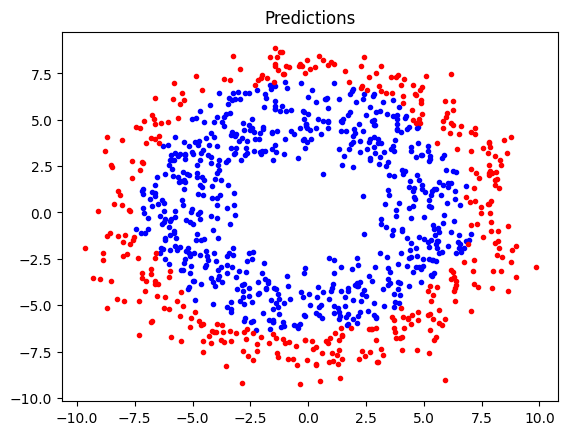

In [18]:
# final prediction on full data
model.eval()
outputs = model(data)
preds = (outputs > 0.5).float()
print(
    "Accuracy on full data: {}".format(
        torch.mean((preds == labels).float()).item() * 100
    )
)

# plot the results
plt.plot(data[np.where(preds == 0)[0], 0], data[np.where(preds == 0)[0], 1], "b.")
plt.plot(data[np.where(preds == 1)[0], 0], data[np.where(preds == 1)[0], 1], "r.")
plt.title("Predictions")
plt.show()

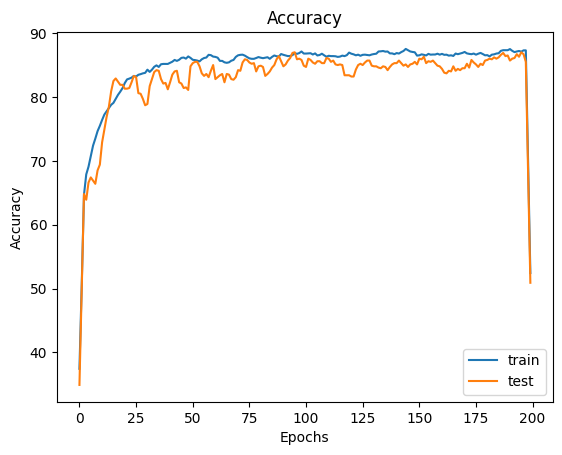

In [19]:
# plot the results
def smooth(x, k=5):
    return np.convolve(x, np.ones(k) / k, mode="same")


plt.plot(smooth(train_acc), label="train")
plt.plot(smooth(test_acc), label="test")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
# various dropout rates
dropout_rates = np.linspace(0, 0.9, 10)
results = []

for dropout_rate in dropout_rates:
    model, loss_fn, optimizer = create_model(dropout_rate)
    train_acc, test_acc = train(model, loss_fn, optimizer, train_loader)
    results.append((np.mean(train_acc[-50:]), np.mean(test_acc[-50:])))
    msg = f"Dropout rate: {dropout_rate:.3} done"
    sys.stdout.write("\r"+msg)

Dropout rate: 0.9 done

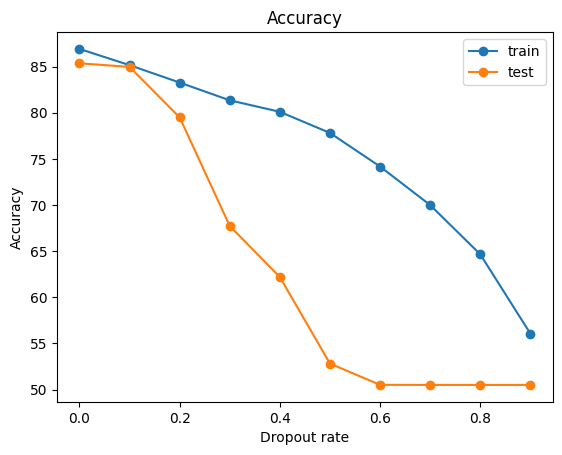

In [21]:
# plot the results
plt.plot(dropout_rates, [x[0] for x in results], label="train", marker="o")
plt.plot(dropout_rates, [x[1] for x in results], label="test", marker="o")
plt.title("Accuracy")
plt.xlabel("Dropout rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()